In [1]:
import logging
from sentinelhub import MimeType, CRS, BBox, DataCollection, bbox_to_dimensions
from sentinelhub import SHConfig, SentinelHubRequest
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
from tools import bbox_geometry_calculator
import numpy as np
from PIL import Image
import os
from sentinel_api import sentinel_single_image, sentinel_territory

### Logging in sentinel account

In [2]:
logging.basicConfig(level=logging.INFO)

# Your client credentials
client_id = 'e0b127dc-fbb5-4151-8946-96d8728003c7'
client_secret = '4Xy2[Bc#?&L!xbha(XB6*%Xbry,BU-cZA0Dd9n,W'

config = SHConfig(instance_id='',
         sh_client_id = client_id,
         sh_client_secret = client_secret,
         sh_base_url='https://services.sentinel-hub.com',
         sh_token_url='https://services.sentinel-hub.com/oauth/token',)

### Test sentinel_single_image 

Territory dimensions: 8,604m x 7,692m | Area: 66 km^2
Requesting images with 10m resolution and region size of (2500, 2500) pixels


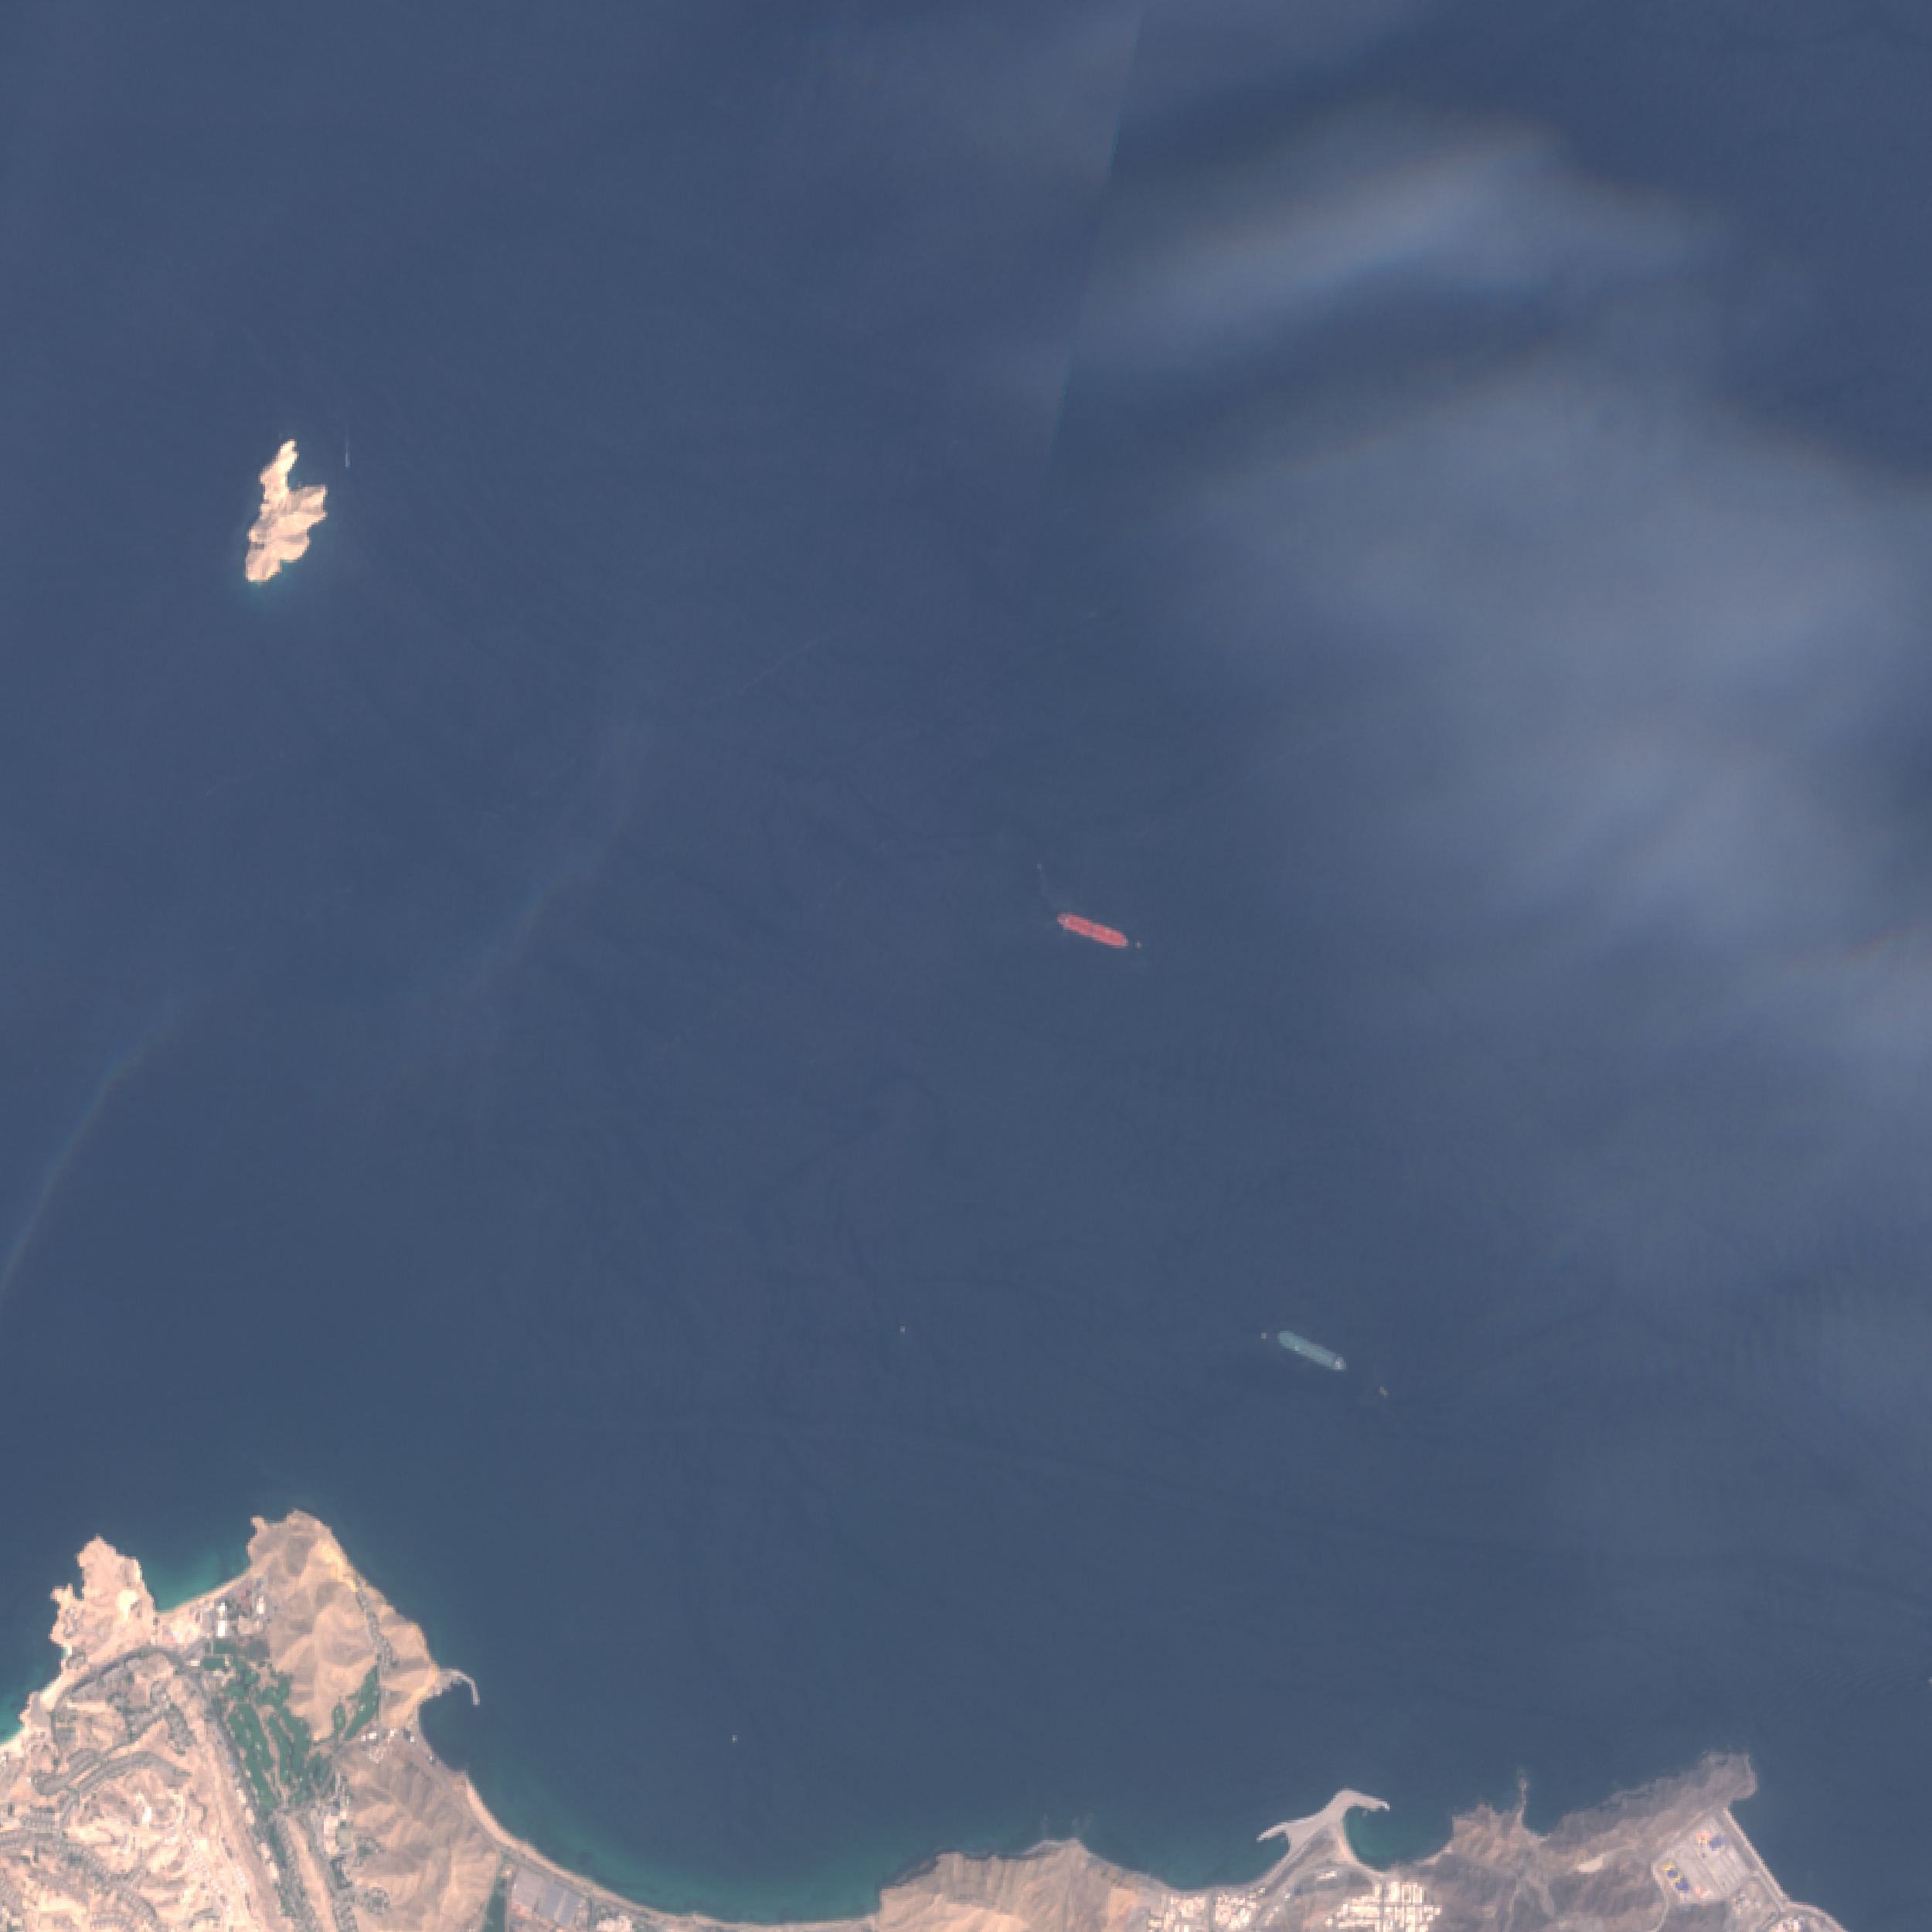

In [4]:
bbox = [58.488808, 23.630371, 58.573265, 23.699550]
# bbox = [15.0000, -30.0000, 15.1000, -30.1000]
timeline = ('2023-07-05', '2023-09-25')

# Parameters
mosaicking_order_modes = ['mostRecent', 'leastCC', 'leastRecent']
data_collection_modes = [DataCollection.SENTINEL2_L2A, DataCollection.SENTINEL2_L1C]

img = sentinel_single_image(bbox, timeline, config=config, data_collection=data_collection_modes[1], mosaicking_order = mosaicking_order_modes[0],
                            resolution=10, maxcc=0.8, img_size=(2500,2500), return_numpy=False, verbose=True, save_image=False, save_dir="sentinel-hub")
img.save(r"C:\Users\user2\Desktop\sentinel-3.png")
img

### Test sentinel_territory

In [7]:
# in disk:
bbox_coords = [58.5, 23.6, 59, 24.1]
timeline = ('2023-07-05', '2023-09-25')

# Parameters
mosaicking_order_modes = ['mostRecent', 'leastCC', 'leastRecent']
data_collection_modes = [DataCollection.SENTINEL2_L2A, DataCollection.SENTINEL2_L1C]

final_image = sentinel_territory(bbox_coords, timeline, config, data_collection=data_collection_modes[1], mosaicking_order = 'mostRecent', maxcc=0.8,
                      resolution=5, img_size=(2500, 2500), save_concat_image=True, in_memory=False, temp_dir=r"sentinel-tmp", )

Territory dimensions: 50,947m x 55,597m | Area: 2,833 km^2
Concatenated image will be in size of 25000 x 25000 p
There are 100 bboxes to download



dl from sentinel-hub | bbox: [58.95, 24.05, 59.0, 24.1]: 100%|███████████████████████| 100/100 [23:46<00:00, 10.00s/it]

All images are downloaded into disk - concatenating images is in progress...
Done!


dl from sentinel-hub | bbox: [58.95, 24.05, 59.0, 24.1]: 100%|███████████████████████| 100/100 [23:56<00:00, 14.36s/it]

concatenated image saved in sentinel-concat


In [ ]:
# in memory:
bbox_coords = [58.5, 23.6, 59, 24.1]
timeline = ('2023-07-05', '2023-09-25')

# Parameters
mosaicking_order_modes = ['mostRecent', 'leastCC', 'leastRecent']
data_collection_modes = [DataCollection.SENTINEL2_L2A, DataCollection.SENTINEL2_L1C]

img_array, final_image = sentinel_territory(bbox_coords, timeline, config, data_collection=data_collection_modes[1], mosaicking_order = 'mostRecent', maxcc=0.8,
                      resolution=10, save_images=False, data_folder="sentinel-hub", subfolder_name="default", img_size=(64, 64))

### Drafts

In [ ]:
logging.basicConfig(level=logging.INFO)

In [ ]:
# Load configuration for sentinel-hub API.
config = SHConfig()

config = SHConfig(instance_id='',
         sh_client_id='e0b127dc-fbb5-4151-8946-96d8728003c7',
         sh_client_secret='4Xy2[Bc#?&L!xbha(XB6*%Xbry,BU-cZA0Dd9n,W',
         sh_base_url='https://services.sentinel-hub.com',
         sh_token_url='https://services.sentinel-hub.com/oauth/token',
)

In [ ]:
# config = SHConfig()
config.instance_id = "my-instance-id"
config.save("my-profile")

In [ ]:
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session

# Your client credentials
client_id = 'e0b127dc-fbb5-4151-8946-96d8728003c7'
client_secret = '4Xy2[Bc#?&L!xbha(XB6*%Xbry,BU-cZA0Dd9n,W'

# Create a session
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)

# Get token for the session
token = oauth.fetch_token(token_url='https://services.sentinel-hub.com/oauth/token',
                          client_secret=client_secret)

# All requests using this session will have an access token automatically added
resp = oauth.get("https://services.sentinel-hub.com/oauth/tokeninfo")
print(resp.content)

In [ ]:
# Bands are set in reverse order.
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [3.5*sample.B04, 3.5*sample.B03, 3.5*sample.B02];

    }
"""

In [ ]:
def request_images(coords_wgs84, timeline):
    """
    Arguments:
        coords_wgs84: WGS84 coordinates (e.g. bboxfinder.com)
        timeline: List of time intervals represented as "yyyy-mm-dd"

    Returns:
        List of images represented as NxMx3 Numpy arrays
    """

    # Set resolution and region bb/size.
    resolution = 10
    region_bbox = BBox(bbox = coords_wgs84, crs = CRS.WGS84)
    region_size = bbox_to_dimensions(region_bbox, resolution = resolution)
    print(f'Requesting images with {resolution}m resolution and region size of {region_size} pixels')

    images = []
    for time_int in timeline:

        # Build the request.
        request_true_color = SentinelHubRequest(
            data_folder='sentinel-hub',
            #resolution = resolution,
            evalscript = evalscript_true_color,
            input_data = [
                SentinelHubRequest.input_data(
                    data_collection = DataCollection.SENTINEL2_L1C,
                    time_interval = time_int,
                    mosaicking_order = 'leastCC'
                )
            ],
            responses = [
                SentinelHubRequest.output_response('default', MimeType.PNG)
            ],
            bbox = region_bbox,
            size = region_size,
            config = config
        )
        # By construction, only one image at time is returned.
        true_color_imgs = request_true_color.get_data(save_data=True)
        images.append(true_color_imgs[0])

    return images

In [ ]:
bbox = [58.488808,23.630371,58.573265,23.699550]
time_interval = ['2023-07-05', '2023-09-25']

In [ ]:
images = request_images(coords_wgs84=bbox, timeline=time_interval)

In [ ]:
from inference_modular import ship_detection

# images_dir = r"D:\NLP 1\Sat_object_detection\debug_images_2"
# images_dir = r"D:\NLP 1\Sat_object_detection\debug_images_3"
# images_dir = r"D:\NLP 1\Sat_object_detection\inference_images"
images_dir = r"C:\Users\user2\Desktop\test"

# coord = {"0c0d90d8d.jpg": [58.4893887115, 23.6396684794, 58.4961460224, 23.6487324542],
#          "2d1b074cb.jpg": [47.3562147890, 26.3220918742, 47.3646843251, 26.3311658917],}

result = ship_detection(images=images_dir, annotations=["length", "coord"], nms_iou_threshold=0.15, scale_down_factor= 1,
                        adaptive_scale_down_parameters = {'a': 0.2, 'b': 0.5, 'threshold': 3}, model_input_dim=768, confidence_threshold=0.7, sahi_overlap_ratio=0.33,
                        output_annotated_image=True, save_annotated_image=True, annotation_font_size=15, annotation_bbox_width=1, output_original_image=True)